# Plotting return period curves from hazard data

This notebook provides a way to plot hazard maps, and interactively plot hazard curves. 

NOTE: This uses Cartopy, not basemap for the mapping functionality. The underlying `PlotInterface` module in TCRM is built on basemap, which is expected to reach end-of-life in 2020. Cartopy is the way of the future.

TODO:
* Currently the average recurrence interval used in the map is fixed. Should be able to change this using a `Dropdown` widget
* Add scale bar to the map plot
* Better choice of colour map (i.e. not "jet" and remains fixed irrespective of ARI selected)
* Graticule, scale bar, etc. for the map
* Make the units a `Dropdown` widget as well
* Load data from the THREDDS data service, rather than the file system access.
* Add a marker on the map to show where the mouse click event was.


In [23]:
%matplotlib notebook

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import numpy as np

import Utilities.nctools as nctools
import Utilities.metutils as metutils
from Utilities.maputils import find_index

from PlotInterface.curves import HazardCurve
import seaborn

import ipywidgets as widgets
from IPython.display import display

Define a class for selecting the units for plotting. Options are: "km/h" (various contractions), "miles per hour", "knots", and "metres per second" (default).

In [8]:
class PlotUnits(object):

    def __init__(self, units):
        labels = {
            'mps': 'm/s',
            'mph': 'mi/h',
            'kts': 'kts',
            'kph': 'km/h',
            'kmh': 'km/h'
        }

        levels = {
            'mps': np.arange(30, 101., 5.),
            'mph': np.arange(80, 221., 10.),
            'kts': np.arange(60, 201., 10.),
            'kph': np.arange(80, 361., 20.),
            'kmh': np.arange(80, 361., 20.)
        }

        self.units = units
        self.label = labels[units]
        self.levels = levels[units]

Now load the data from what is stored on the "fj6" data project. Preferably, this would actually point to the THREDDS data service.

In [9]:
plotUnits = PlotUnits('mps')

url = "/g/data/fj6/TCRM/benchmark/hazard/hazard.nc"

ncobj = nctools.ncLoadFile(url)
lon = nctools.ncGetDims(ncobj, 'lon')
lat = nctools.ncGetDims(ncobj, 'lat')
years = nctools.ncGetDims(ncobj, 'return_period')

wspd = nctools.ncGetVar(ncobj, 'wspd')
try:
    wLower  = nctools.ncGetVar(ncobj, 'wspdlower')
    wUpper = nctools.ncGetVar(ncobj, 'wspdupper')
    ciBounds = True
except KeyError:
    ciBounds = False

minLon = min(lon)
maxLon = max(lon)
minLat = min(lat)
maxLat = max(lat)

defaultMax = np.ceil(metutils.convert(100.0, 'mps', plotUnits.units)/10.0)*10.0
palette = seaborn.color_palette("YlOrRd", 7)
cmap = seaborn.blend_palette(palette, as_cmap=True)

Create the map of hazard data. Here, we also define the actions for a click event in the map figure. All that really is to add the attributes of the event (location in figure coords, locaiton in data coords, button) to the widget that is used to display the map.

After running this code, we can click anywhere on the map and the coordinates are stored in the widget object (i.e. the `w` variable), so we can access them for plotting the curve.

NOTE: This notebook uses a simple plotting routine to display the hazard map. TCRM has an existing `HazardMap` method in `PlotInterface.maps` that can be used to plot the map. However, this notebook is in part testing the ability to use `Cartopy` for handling the mapping aspects of plotting. The virtual environment that I'm running this in does not have `Basemap` installed, so the `HazardMap` method doesn't work.

<IPython.core.display.Javascript object>


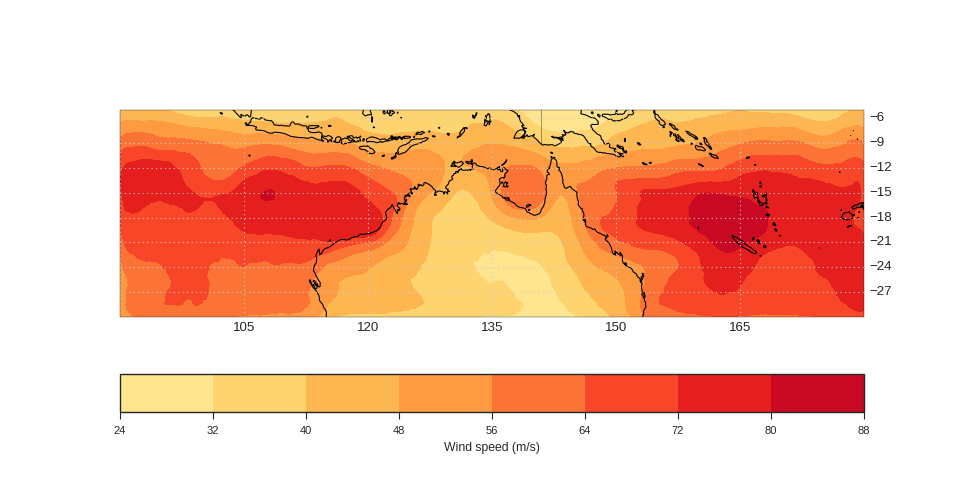

The installed widget Javascript is the wrong version.


In [26]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cm = ax.contourf(lon, lat, wspd[5,:,:], cmap=cmap)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(feature.BORDERS)
gl = ax.gridlines(linestyle=":", draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
plt.colorbar(cm, orientation='horizontal',extend='both',
             label="Wind speed ({0})".format(plotUnits.label))

w = widgets.HTML()

def onclick(event):
    w.value = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(
              event.button, event.x, event.y, event.xdata, event.ydata)
    w.event = event
    print(w.event.xdata, w.event.ydata)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

Once we click somewhere on the map, we use the attributes in the `w` variable to extract the coordinates and pull the data for the hazard curve.

In [27]:
plat, plon = [w.event.ydata, w.event.xdata]

i = find_index(lon, plon)
j = find_index(lat, plat)

pWspd = metutils.convert(wspd[:, j, i], 'mps', plotUnits.units)
if ciBounds:
    pWspdLower = metutils.convert(wLower[:,j,i], 'mps', plotUnits.units)
    pWspdUpper = metutils.convert(wUpper[:,j,i], 'mps', plotUnits.units)
    

Last thing to do is to plot the hazard curve! We use the `HazardCurve` function in the `PlotInterface` module from TCRM, so it's consistent with automatically generated plots. I think that has been updated in recent revisions.

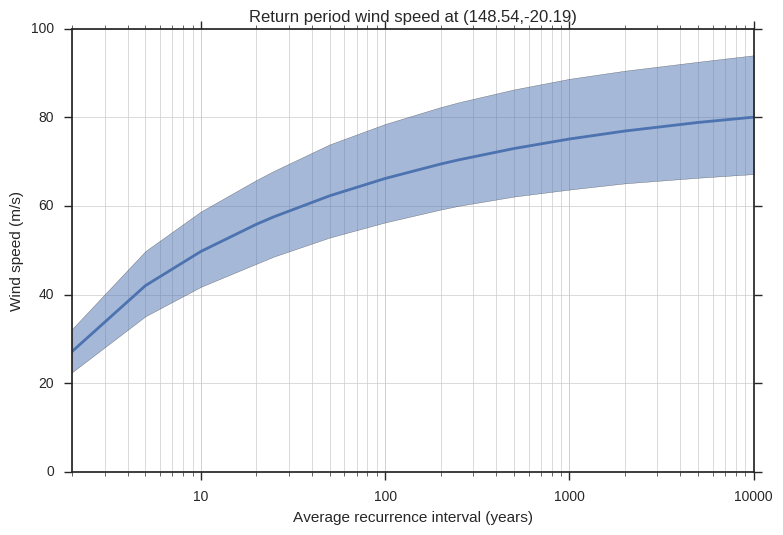

In [28]:
xlabel = 'Average recurrence interval (years)'
ylabel = 'Wind speed ({0})'.format(plotUnits.label)
title = "Return period wind speed at ({0:.2f},{1:.2f})".format(plon, plat)

fig = HazardCurve()
fig.plot(years, pWspd, pWspdUpper, pWspdLower, xlabel, ylabel, title)
fig